# Neuse River Waterdog - GBIF Records Summary
This notebook is a tool for exploring data sets requested from GBIF (and eventually other sources), and mostly for developing criteria for filtering records (filter sets).  When the entire notebook is run, it retrieves records according to the filter sets specified and saves the results (records and some summary tables) in an sqlite database.  Some information is pulled from the parameters.sqlite database that is saved in this repository.

### General Setup

In [1]:
%matplotlib inline
import sqlite3
import pprint
import json
import pandas as pd
import numpy as np
#import geopandas as gpd
pd.set_option('display.width', 600)
pd.set_option('display.max_colwidth', 60)
pd.set_option('display.max_rows', 150)
from IPython.display import Image
from pygbif import occurrences
import matplotlib.pyplot as plt
import os
from datetime import datetime
t1 = datetime.now()

### Config file
Some of the scripts below pull variables from a config file.  This is in order to reduce redundancy and also facilitates running scripts outside of jupyter notebooks.  However, variables need to be able to be set in notebooks too, so the cell below deletes and then rewrites the config file according to what you want for running this notebook.

In [2]:
# Set variables in the following text string, not variable assignment below.
text = """#NOTE! this is overwritten by some notebooks, so update everywhere, if adding lines.
sp_id = 'anrwax0'
summary_name = 'waterdog'
gbif_req_id = 'GBIFr10'
gbif_filter_id = 'GBIFf5'
ebird_req_id = None
ebird_filter_id = None
evaluation = 'eval_gbif1'
workDir = '/Users/nmtarr/Documents/RANGES/'
codeDir = '/Users/nmtarr/Code/range_map_evaluation/'
inDir = workDir + 'Inputs/'
outDir = workDir + 'Outputs/'
default_coordUncertainty = 500
SRID_dict = {'WGS84': 4326, 'AlbersNAD83': 102008} # Used in file names for output.
spdb = outDir + sp_id + gbif_req_id + gbif_filter_id + '.sqlite'
"""
f = open('config.py', 'w')
f.write(text)
f.close()

import config
species_id = config.sp_id
summary_name = config.summary_name
request_id = config.gbif_req_id
filter_id = config.gbif_filter_id
inDir = config.inDir
outDir = config.outDir
print("Notebook run " + str(t1))

Notebook run 2019-05-15 14:09:02.552026


In [3]:
connjup = sqlite3.connect(config.codeDir + 'parameters.sqlite')
cursorjup = connjup.cursor()

# Species Concept
Display information on the species from the parameters.sqlite database.

In [4]:
vals = cursorjup.execute("SELECT * FROM species_concepts WHERE species_id = '{0}';".format(species_id)).fetchall()[0]
cols = [x[1] for x in cursorjup.execute("PRAGMA table_info('species_concepts')").fetchall()]
pprint.pprint(dict(zip(cols, vals)))

{'bcb_id': None,
 'breeding_months': '',
 'common_name': 'neuse river waterdog',
 'detection_distance_meters': 0,
 'end_year': '',
 'error_tolerance': 5,
 'fws_id': 'Necturus lewisi',
 'gap_id': 'anrwax',
 'gbif_id': '2432046',
 'geometry': '',
 'itis_tsn': '173627',
 'migratory': '0',
 'notes': None,
 'pad': 1,
 'scientific_name': 'Necturus lewisi',
 'species_id': 'anrwax0',
 'start_year': 1937,
 'wintering_months': ''}


## Filters
Display the parameters of the request filter set.  These are deployed during the step where records are retrieved from the API.

In [5]:
df1 = pd.read_sql_query(sql="SELECT * FROM gbif_requests WHERE request_id = '{0}'".format(request_id), con=connjup)
print("THE REQUEST FILTER SET")
print(df1.loc[0])

THE REQUEST FILTER SET
request_id                                 GBIFr10
source                                        GBIF
lat_range                                    27,41
lon_range                                  -91,-75
years_range                              1998,2020
months_range                                  1,12
geoissue                                      None
coordinate                                    True
continent                                     None
creator                                    N. Tarr
notes           Developed for Eastern Indigo Snake
Name: 0, dtype: object


Display the parameters of the post-request filter set.  These are deployed after the records are retrieved from the API, but before they are stored in the occurrence record sqlite database.

In [6]:
df2 = pd.read_sql_query(sql="SELECT * FROM gbif_filters WHERE filter_id = '{0}'".format(filter_id), con=connjup)
print("THE POST REQUEST FILTER SET")
print(df2.loc[0])

THE POST REQUEST FILTER SET
filter_id                                                                          GBIFf5
dataset                                                                              GBIF
collection_codes_omit                                                                    
institutions_omit                                                                        
has_coordinate_uncertainty                                                              0
max_coordinate_uncertainty                                                           1000
bases_omit                                                                FOSSIL_SPECIMEN
protocols_omit                                                                           
sampling_protocols_omit                                                                  
issues_omit                   GEODETIC_DATUM_INVALID, INDIVIDUAL_COUNT_INVALID, MULTIM...
creator                                                                 

### Filter set justification
collection_codes_omit: --

institutions_omit: --

has_coordinate_uncertainty: --

max_coordinate_uncertainty: No real logic behind the choice.

bases_omit: Preserved_specimens seem reliable for this species to me and fossils don't seem relevant to this application.

protocols_omit: --

sampling_protocols_omit: --

issues_omit: Invalid datums create spatial error in point locations.  Invalid counts seem like a red flag for data quality.

In [7]:
# Run a script that retrieves and filters
%run 'retrieve_occurrences.py'

downloading https://www.sciencebase.gov/catalog/file/get/59f5e257e4b063d5d307de11?f=__disk__fb%2Fda%2F98%2Ffbda9809436cb36af7215c11c8dcd7d040883dcf to /Users/nmtarr/Documents/RANGES/Inputs/aNRWAx_CONUS_Range_2001v1.zip
downloading https://www.sciencebase.gov/catalog/file/get/59f5e257e4b063d5d307de11?f=__disk__56%2Ff9%2Fc3%2F56f9c3799d98294de98d8ba72ed7054692fdc421 to /Users/nmtarr/Documents/RANGES/Inputs/aNRWAx_CONUS_Range_2001v1.xml
8 records exist with the request parameters
['GEODETIC_DATUM_INVALID', 'INDIVIDUAL_COUNT_INVALID', 'MULTIMEDIA_DATE_INVALID', 'COORDINATE_UNCERTAINTY_METERS_INVALID']
Records saved in /Users/nmtarr/Documents/RANGES/Outputs/anrwax0GBIFr10GBIFf5.sqlite


### How many records made it through the filters?
This is the number that was actually saved in the occurrence record sqlite database.

In [8]:
conn_occ= sqlite3.connect(config.spdb)
curs_occ = conn_occ.cursor()
record_count = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences WHERE species_id = '{0}'".format(species_id)).fetchone()
print(str(record_count[0]) + " records")

6 records


### Were there duplicate records?
needs to be addressed

In [9]:
dups0 = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences GROUP BY geom_xy4326, occurrenceDate;").fetchall()
dups1 = [x[0] for x in dups0]
dups2 = [x for x in dups1 if x > 1]
print(str(len(dups2)) + ' records were duplicates based on xy coordinate and date-time')

0 records were duplicates based on xy coordinate and date-time


# Institutions
#### Pre-filters

In [10]:
institutions = curs_occ.execute("SELECT value, count FROM post_request_value_counts WHERE attribute = 'institutions';").fetchall()
for x in institutions:
    print(x[0] + " ({0})".format(x[1]))

iNaturalist (2)
NCSM (6)


#### Post-filter

In [11]:
institutions = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'institutions' AND step = 'filter';").fetchone()[0]
institutions = institutions.replace('[', '').strip().replace(']', '').replace("'", "")
institutions = institutions.split(',')
for ins in institutions:
    print(ins.strip())

NCSM


# Collections
#### Pre-filters

In [12]:
collections = curs_occ.execute("SELECT value, count FROM post_request_value_counts WHERE attribute = 'collections';").fetchall()
for x in collections:
    print(x[0] + " ({0})".format(x[1]))

Observations (2)
NCSM-Herp (6)


#### Post-filters

In [13]:
collections = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'collections' AND step = 'filter';").fetchone()[0]
collections = collections.replace('[', '').strip().replace(']', '').replace("'", "")
collections = collections.split(',')
for colls in collections:
    print(colls.strip())

NCSM-Herp


# Bases
#### Pre-filter

In [14]:
bases = curs_occ.execute("SELECT value, count FROM post_request_value_counts WHERE attribute = 'bases';").fetchall()
for x in bases:
    print(x[0] + " ({0})".format(x[1]))

HUMAN_OBSERVATION (2)
PRESERVED_SPECIMEN (6)


#### Post-filters

In [15]:
bases = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'bases' AND step = 'filter';").fetchone()[0]
bases = bases.replace('[', '').strip().replace(']', '').replace("'", "")
bases = bases.split(",")
for bas in bases:
    print(bas.strip())

PRESERVED_SPECIMEN


# Protocols
#### Pre-filters

In [16]:
protocols = curs_occ.execute("SELECT value, count FROM post_request_value_counts WHERE attribute = 'protocols';").fetchall()
for x in protocols:
    print(x[0] + " ({0})".format(x[1]))

DWC_ARCHIVE (8)


#### Post-filters

In [17]:
protos = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'protocols' AND step = 'filter';").fetchall()[0]
for pro in protos:
    pro = pro.replace('[', '').strip().replace(']', '').replace("'", "")
    print(pro)

DWC_ARCHIVE


# Issues
#### Pre-filters

In [18]:
issues = curs_occ.execute("SELECT value, count FROM post_request_value_counts WHERE attribute = 'issues';").fetchall()
for x in issues:
    print(x[0] + " ({0})".format(x[1]))

COORDINATE_ROUNDED (3)
GEODETIC_DATUM_ASSUMED_WGS84 (3)


#### Post-filters

In [32]:
issues = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'issues' AND step = 'filter';").fetchone()[0]
issues = issues.replace('[', '').strip().replace(']', '').replace("'", "")
issues = issues.split(',')
for iss in issues:
    print(iss.strip())

# Descriptions of filtered records

### Locations

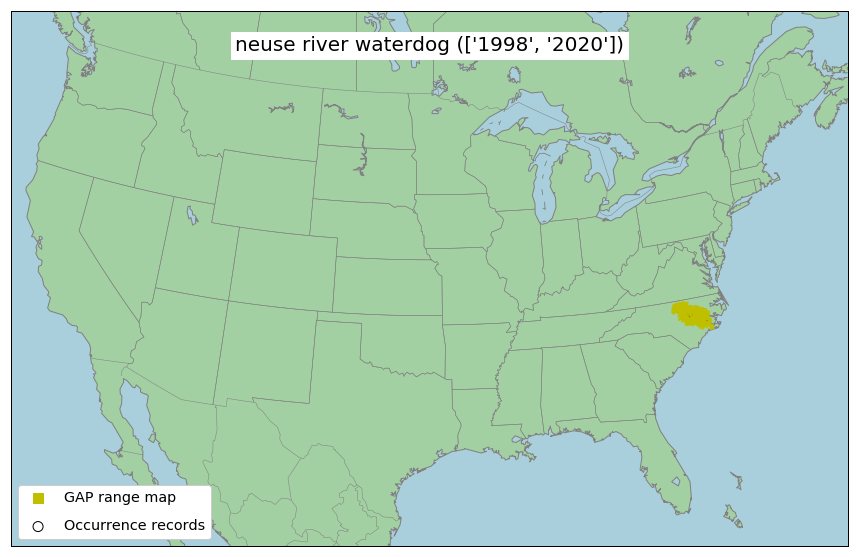

In [33]:
gap_range2 = "{0}{1}_range_4326".format(inDir, gap_id)

shp1 = {'file': gap_range2, 'column': None, 'alias': 'GAP range map',
        'drawbounds': False, 'linewidth': .5, 'linecolor': 'y',
        'fillcolor': 'y', 'marker':'s'}

shp2 = {'file': '{0}{1}_circles'.format(outDir, summary_name), 'column': None,
        'alias': 'Occurrence records', 'drawbounds': True, 'linewidth': .75, 'linecolor': 'k',
        'fillcolor': None, 'marker':'o'}

# Display occurrence polygons
if os.path.isfile(gap_range2 + ".shp"):
    map_these=[shp1, shp2]
else:
    map_these=[shp2]
    
title="{1} ({0})".format(years, common_name)
functions.MapShapefilePolygons(map_these=map_these, title=title)

### Years represented

Text(0.5, 1.0, 'Occurrences per Year')

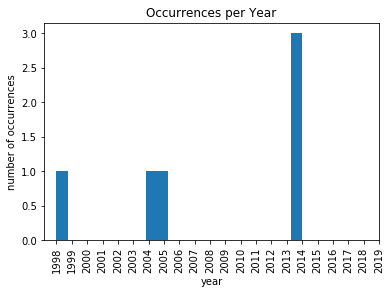

In [21]:
occ_years = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%Y', occurrenceDate) FROM occurrences").fetchall()]
years = connjup.execute("SELECT years_range FROM gbif_requests WHERE request_id = '{0}'".format(config.gbif_req_id)).fetchone()[0]
years = years.split(',')
yearsrng = list(range(int(years[0]), int(years[1]), 1))
binsnum = int(years[1]) - int(years[0])
plt.hist(occ_years, bins=binsnum)
plt.ylabel("number of occurrences")
plt.xlabel("year")
plt.xticks(yearsrng, rotation=90)
plt.title("Occurrences per Year")

### Months represented

Text(0.5, 1.0, 'Occurrences per Month')

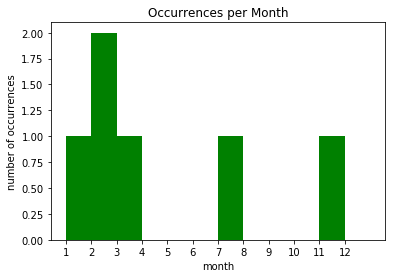

In [22]:
occ_months = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%m', occurrenceDate) FROM occurrences").fetchall()]
plt.hist(occ_months, bins=range(1, 14), color="g")
plt.ylabel("number of occurrences")
plt.xlabel("month")
plt.xticks(range(1, 13))
plt.title("Occurrences per Month")

### Distribution of coordinate uncertainty values

Text(0.5, 1.0, 'Coordinate Uncertainty')

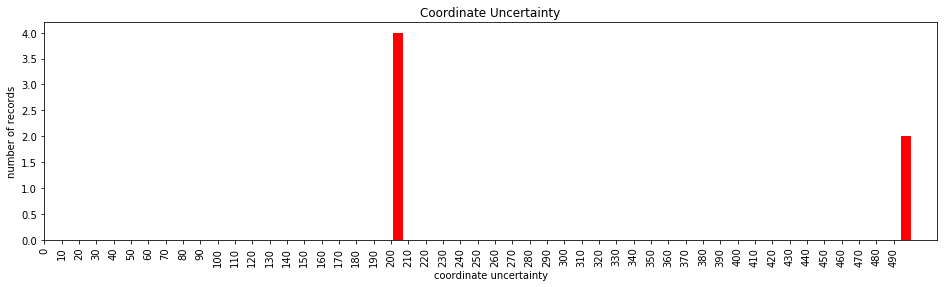

In [23]:
occ_cert = [int(x[0]) for x in curs_occ.execute("SELECT coordinateUncertaintyInMeters FROM occurrences").fetchall()]
maxi = np.max(occ_cert)
plt.figure(figsize=(16,4))
plt.hist(occ_cert, bins=50, color="r")
plt.xticks(range(0, maxi, int(maxi/50)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty")

Text(0.5, 1.0, 'Coordinate Uncertainty')

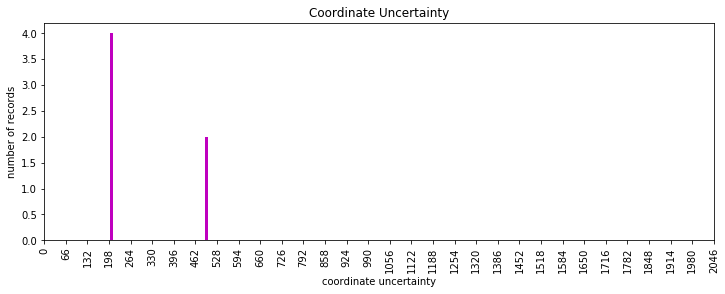

In [24]:
rng_max = 2000
occ_cert2 = [x for x in occ_cert if x <= rng_max]
plt.figure(figsize=(12,4))
plt.hist(occ_cert2, bins=30, color="m", align='mid')
plt.xticks(range(0, rng_max + 100, int(rng_max/30.)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty")

### Geodetic datums present

In [25]:
datums = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'datums' AND step = 'filter';").fetchone()[0]
datums = datums.replace('[', '').strip().replace(']', '').replace("'", "")
datums = datums.split()
for datum in datums:
    print(datum)

WGS84


### Establishment means reported

In [26]:
establishment = curs_occ.execute("SELECT vals FROM record_attributes WHERE field = 'establishment' AND step = 'filter';").fetchall()[0]
for est in establishment:
    est = est.replace('[', '').strip().replace(']', '').replace("'", "")
    print(est)

### Identification qualifiers included

In [27]:
quali = curs_occ.execute("SELECT DISTINCT vals FROM record_attributes WHERE field = 'IDqualifier' AND step = 'filter';").fetchall()[0]
for q in quali:
    q = q.replace('[', '').strip().replace(']', '').replace("'", "")
    print(q)

### Remarks included

In [28]:
remarks = curs_occ.execute("SELECT DISTINCT remarks FROM occurrences;").fetchall()
#remarks = remarks.replace('[', '').strip().replace(']', '').replace("'", "")
#remarks = remarks.split(',')
if len(remarks) <= 20:
    for rem in remarks:
        if rem[0][0:1] == ';':
            print(rem[0][2:])
        else:
            print(rem[0])
else:
    print("More than 20 remarks, consult the occurrence database.")

11.2 miles E ClaytonCaught in minnow trap. Died in captivity 7 June 1999.
3.5 air miles  ENE JasperCaught by fisherman; taken to veterinarian for hook removal; later died
3.1 mi. N Bagley
[ca. 6.0 air] miles [NE center] Archer Lodge, Little River at NC 96
2.3 miles ENE Rock Ridge, Contentnea Creek at SR 1154 (Saint Rose Church Road)
4.1 miles ESE Glenview, Fishing Creek at SR 1222 [Bellamy Mill Road]/Nash County line


### Sources

In [29]:
tables = cursorjup.execute("SELECT table_name FROM table_descriptions").fetchall()
tables = [x[0] for x in tables]

filter_sets = [request_id, filter_id]

sources = []
for s in filter_sets:
    s = s.strip()
    for tab in tables:
        columns = cursorjup.execute("SELECT column_name FROM column_descriptions WHERE table_name = '{0}'".format(tab)).fetchall()
        columns = [x[0] for x in columns]
        for col in columns:
            try:
                a = cursorjup.execute("SELECT source FROM {1} WHERE {2} = '{0}'".format(s, tab, col)).fetchone()[0]
                sources.append(a)
            except:
                pass
print(list(set(sources))[0])

GBIF


### Attributes returned for the records in the request (pre-filters)

In [30]:
fields_summary = pd.read_sql("SELECT * FROM gbif_fields_returned", conn_occ, index_col='index')
fields_summary.index.name = 'field'
print(fields_summary)

                                      included(n)  populated(n)
field                                                          
acceptedScientificName                          8             8
acceptedTaxonKey                                8             8
accessRights                                    6             6
basisOfRecord                                   8             8
bibliographicCitation                           6             6
catalogNumber                                   8             8
class                                           8             8
classKey                                        8             8
collectionCode                                  8             8
continent                                       6             6
coordinateUncertaintyInMeters                   6             6
country                                         8             8
countryCode                                     8             8
county                                  

### Runtime

In [31]:
t2 = datetime.now()
print(t2 - t1)

0:00:37.038484
